In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

plt.style.use('ggplot')

In [2]:
cd ..

/Users/odatakuma/cmu/FleetAI


## Preprocessing

In [3]:
df = pd.read_csv('data/nyc_taxi/trips_2016-05.csv',
                 usecols=[
                     'phash',
                     'hour',
                     'minute',
                     'dayofweek',
                     'date'
                 ], dtype={
                     'hour':np.float32,
                     'minute':np.int16,
                     'dayofweek':np.int16,
                     'date':np.int16
                 }
                )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12806249 entries, 0 to 12806248
Data columns (total 5 columns):
date         int16
dayofweek    int16
hour         float32
minute       int16
phash        object
dtypes: float32(1), int16(3), object(1)
memory usage: 317.5+ MB


In [4]:
df['hour'] += 0.5 * (df.minute / 30).astype(int)
df.hour.unique()

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5])

In [5]:
demand = df.groupby(['date', 'dayofweek', 'hour', 'phash'])[['minute']].count().rename(columns={'minute':'count'})
demand.head()

count
date dayofweek hour phash         
1    6         0    dr5qupn      1
                    dr5r56q      1
                    dr5r5wk      1
                    dr5r5ww      1
                    dr5r5zg      1

In [6]:
demand = demand.reset_index()
demand['date_dayofweek_hour'] = zip(demand.date, demand.dayofweek, demand.hour)
demand.head()

,date,dayofweek,hour,phash,count,date_dayofweek_hour
0,1,6,0,dr5qupn,1,"(1, 6, 0.0)"
1,1,6,0,dr5r56q,1,"(1, 6, 0.0)"
2,1,6,0,dr5r5wk,1,"(1, 6, 0.0)"
3,1,6,0,dr5r5ww,1,"(1, 6, 0.0)"
4,1,6,0,dr5r5zg,1,"(1, 6, 0.0)"


In [7]:
demand_pivot = demand.pivot(index='date_dayofweek_hour', columns='phash', values='count')
demand_pivot = demand_pivot.fillna(0)
demand_pivot.head()

phash,dr5qgxz,dr5qgz5,dr5qgz7,dr5qgz8,dr5qgzc,dr5qgze,dr5qgzr,dr5qgzu,dr5qgzw,dr5qup0,...,dr78818,dr7881c,dr7881d,dr7881f,dr7881g,dr7882y,dr78842,dr78843,dr78848,dr78849
date_dayofweek_hour,,,,,,,,,,,,,,,,,,,,,
"(1, 6, 0.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 0.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 1.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 1.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 2.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
del df

In [9]:
demand_pivot['date'] = 0
demand_pivot['dayofweek'] = 0
demand_pivot['hour'] = 0
demand_pivot[['date', 'dayofweek', 'hour']] = list(demand_pivot.index.values)
demand = pd.melt(demand_pivot, id_vars=['date', 'dayofweek', 'hour'])
demand = demand.rename(columns={'phash':'geohash', 'value':'demand'})
demand.head()

,date,dayofweek,hour,geohash,demand
0,1,6,0.0,dr5qgxz,0
1,1,6,0.5,dr5qgxz,0
2,1,6,1.0,dr5qgxz,0
3,1,6,1.5,dr5qgxz,0
4,1,6,2.0,dr5qgxz,0


In [10]:
zones = pd.read_csv("data/table/zones.csv",
                    usecols=['geohash', 'lat', 'lon', 'road_density', 'intxn_density'])
zones.head()

,geohash,lat,lon,road_density,intxn_density
0,dr5qgxx,40.603358,-74.015682,32,35
1,dr5qgxy,40.604832,-74.017029,34,8
2,dr5qgxz,40.604637,-74.015335,0,0
3,dr5qgz5,40.600984,-74.009745,13,5
4,dr5qgz7,40.602178,-74.010322,28,9


In [11]:
demand = demand.sort_values(by=['date', 'hour'])
demand = demand.merge(zones, how='left', on='geohash')
demand.head()

,date,dayofweek,hour,geohash,demand,lat,lon,road_density,intxn_density
0,1,6,0,dr5qgxz,0,40.604637,-74.015335,0,0
1,1,6,0,dr5qgz5,0,40.600984,-74.009745,13,5
2,1,6,0,dr5qgz7,0,40.602178,-74.010322,28,9
3,1,6,0,dr5qgz8,0,40.603474,-74.014180,49,14
4,1,6,0,dr5qgzc,0,40.604756,-74.012782,6,2


In [14]:
demand = demand.drop('geohash', axis=1)
demand.to_csv('data/nyc_taxi/trips/demand_2016_05.csv', index=False)

In [15]:
del demand

In [22]:
df = pd.read_csv('data/nyc_taxi/trips/demand_2016_05.csv',
                dtype={
                    'date':np.int32,
                    'dayofweek':np.int32,
                    'hour':np.float32,
                    'demand':np.int32,
                    'lat':np.float32,
                    'lon':np.float32,
                    'road_density':np.int32
                }).drop('intxn_density', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25252848 entries, 0 to 25252847
Data columns (total 7 columns):
date            int32
dayofweek       int32
hour            float32
demand          int32
lat             float32
lon             float32
road_density    int32
dtypes: float32(3), int32(4)
memory usage: 867.0 MB


In [23]:
def create_features(df):
    df['weekend'] = (df.dayofweek > 4).astype(np.int32)
    df['dayofweek_sin'] = np.sin(df.dayofweek/7.0).astype(np.float32)
    df['dayofweek_cos'] = np.cos(df.dayofweek/7.0).astype(np.float32)
    df['hour_sin'] = np.sin(df.hour/24.0).astype(np.float32)
    df['hour_cos'] = np.cos(df.hour/24.0).astype(np.float32)
    df = df.sort_values(by=['lat', 'lon'])
    df['prev_demand1'] = np.int32(0)
    df['prev_demand1'].iloc[1:] = df['demand'].values[:-1]
    df['prev_demand2'] = np.int32(0)
    df['prev_demand2'].iloc[1:] = df['prev_demand1'].values[:-1]
    df = df[(df.date>1)|(df.hour>1)]
    df = df.sort_values(by=['date', 'hour'])
    return df

df = create_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25201935 entries, 50942 to 25252684
Data columns (total 14 columns):
date             int32
dayofweek        int32
hour             float32
demand           int32
lat              float32
lon              float32
road_density     int32
weekend          int32
dayofweek_sin    float32
dayofweek_cos    float32
hour_sin         float32
hour_cos         float32
prev_demand1     int32
prev_demand2     int32
dtypes: float32(7), int32(7)
memory usage: 1.5 GB


In [36]:
X = df.drop(['demand', 'date'], axis=1).values
y = df['demand'].values
N = int(len(y)*0.7)
X_train, X_test, y_train, y_test = X[:N], X[N:], y[:N], y[N:]
print len(X_train)
print len(X_test)

17641354
7560581


In [37]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

In [38]:
print y_train[y_train>0].size/float(y_train.size)
print y_test[y_test>0].size/float(y_test.size)
print (y_train**2).mean()
print (y_test**2).mean()

0.116865576191
0.111542353689
7.41265165928
6.08425767808


## Benchmark

In [39]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)
rmse_train = np.sqrt(((y_train - slr.predict(X_train))**2).mean())
rmse_test = np.sqrt(((y_test - slr.predict(X_test))**2).mean())
print "RMSE train/val: %.2f / %.2f" % (rmse_train, rmse_test)

RMSE train/val: 1.19 / 1.11


## Ensemble Methods

In [50]:
use_cols = [u'dayofweek', u'hour', u'lat', u'lon', u'road_density', u'prev_demand1', u'prev_demand2']
X = df[use_cols].values
y = df['demand'].values
N = int(len(y)*0.7)
X_train, X_test, y_train, y_test = X[:N], X[N:], y[:N], y[N:]

In [34]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

lr = 1.0
s = 0.2
for d in [2, 4]:
    for n in [10, 20]:
        gbr = GradientBoostingRegressor(learning_rate=lr, n_estimators=n, subsample=s, max_depth=d)
        gbr.fit(X_train, y_train)
        rmse_train = np.sqrt(((y_train - gbr.predict(X_train))**2).mean())
        rmse_test = np.sqrt(((y_test - gbr.predict(X_test))**2).mean())
        print "d=%d, n=%d, RMSE train/val: %.2f / %.2f" % (d, n, rmse_train, rmse_test)

d=2, n=10, RMSE train/val: 1.22 / 1.14
d=2, n=20, RMSE train/val: 1.20 / 1.13
d=4, n=10, RMSE train/val: 1.20 / 1.13
d=4, n=20, RMSE train/val: 1.24 / 1.21
CPU times: user 12min 17s, sys: 1min 3s, total: 13min 20s
Wall time: 13min 27s


In [35]:
%%time
from sklearn.ensemble import RandomForestRegressor

for s in [5e-5, 2e-5]:
    for n in [10, 20]:
        forest = RandomForestRegressor(n_estimators=n,
                                       min_samples_split=s,
                                       n_jobs=-1)
        forest.fit(X_train, y_train)
        rmse_train = np.sqrt(((y_train - forest.predict(X_train))**2).mean())
        rmse_test = np.sqrt(((y_test - forest.predict(X_test))**2).mean())
        print "s=%f, n=%d, RMSE train/val: %.2f / %.2f" % (s, n, rmse_train, rmse_test)

s=0.000050, n=10, RMSE train/val: 1.14 / 1.08
s=0.000050, n=20, RMSE train/val: 1.13 / 1.08
s=0.000020, n=10, RMSE train/val: 1.10 / 1.06
s=0.000020, n=20, RMSE train/val: 1.10 / 1.06
CPU times: user 3h 37min 6s, sys: 1min 23s, total: 3h 38min 30s
Wall time: 59min 5s


In [51]:
forest = RandomForestRegressor(n_estimators=10,
                               min_samples_split=2e-5,
                               n_jobs=-1)
forest.fit(X_train, y_train)
rmse_train = np.sqrt(((y_train - forest.predict(X_train))**2).mean())
rmse_test = np.sqrt(((y_test - forest.predict(X_test))**2).mean())
print "RMSE train/val: %.2f / %.2f" % (rmse_train, rmse_test)

RMSE train/val: 1.10 / 1.06


In [52]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print ("%2d) %s %.4f" %(f+1, use_cols[indices[f]], importances[indices[f]]) )

 1) prev_demand1 0.9315
 2) prev_demand2 0.0414
 3) hour 0.0102
 4) lat 0.0062
 5) lon 0.0061
 6) road_density 0.0035
 7) dayofweek 0.0011


In [53]:
path = 'data/pickle/demand_predictor.pkl'
with open(path, 'wb') as f:
    pickle.dump(forest, f)

## Linear Regression

In [8]:
# from sklearn.linear_model import LinearRegression

# slr = LinearRegression()
# slr.fit(X_train, y_train)
# rmse_train = np.sqrt(((y_train - slr.predict(X_train))**2).mean())
# rmse_test = np.sqrt(((y_test - slr.predict(X_test))**2).mean())
# print "RMSE train/val: %.1f / %.1f" % (rmse_train, rmse_test)

RMSE train/val: 2.3 / 2.1


## Gradient Boosting

In [9]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

lr = 1.0
s = 0.2
for d in [2, 4]:
    for n in [10, 20]:
        gbr = GradientBoostingRegressor(learning_rate=lr, n_estimators=n, subsample=s, max_depth=d)
        gbr.fit(X_train, y_train)
        rmse_train = np.sqrt(((y_train - gbr.predict(X_train))**2).mean())
        rmse_test = np.sqrt(((y_test - gbr.predict(X_test))**2).mean())
        print "d=%d, n=%d, RMSE train/val: %.1f / %.1f" % (d, n, rmse_train, rmse_test)

d=2, n=10, RMSE train/val: 2.3 / 2.1
d=2, n=20, RMSE train/val: 2.3 / 2.1
d=4, n=10, RMSE train/val: 2.3 / 2.1
d=4, n=20, RMSE train/val: 2.3 / 2.4
CPU times: user 6min 56s, sys: 26.5 s, total: 7min 22s
Wall time: 7min 32s


## Random Forest

In [10]:
%%time
from sklearn.ensemble import RandomForestRegressor

for s in [5e-5, 2e-5]:
    for n in [10, 20]:
        forest = RandomForestRegressor(n_estimators=n,
                                       min_samples_split=s,
                                       n_jobs=-1)
        forest.fit(X_train, y_train)
        rmse_train = np.sqrt(((y_train - forest.predict(X_train))**2).mean())
        rmse_test = np.sqrt(((y_test - forest.predict(X_test))**2).mean())
        print "s=%f, n=%d, RMSE train/val: %.1f / %.1f" % (s, n, rmse_train, rmse_test)

s=0.000050, n=10, RMSE train/val: 2.0 / 1.9
s=0.000050, n=20, RMSE train/val: 2.0 / 1.9
s=0.000020, n=10, RMSE train/val: 1.9 / 1.8
s=0.000020, n=20, RMSE train/val: 1.9 / 1.8
CPU times: user 1h 51min 33s, sys: 25.8 s, total: 1h 51min 59s
Wall time: 30min 23s


## Neural Network

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense

def MLP(size, act='relu'):
    model = Sequential()
    model.add(Dense(size, input_dim=12, activation=act))
    model.add(Dense(size, activation=act))
    model.add(Dense(size, activation=act))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_squared_error',  optimizer='adam')
    return model

Using TensorFlow backend.


In [14]:
%%time
mlp = MLP(64)
mlp.fit(X_train, y_train, nb_epoch=10, batch_size=1000, verbose=2, validation_split=0.0)

Epoch 1/10
57s - loss: 5.1477
Epoch 2/10
51s - loss: 4.7087
Epoch 3/10
52s - loss: 4.5752
Epoch 4/10
51s - loss: 4.5060
Epoch 5/10
51s - loss: 4.3990
Epoch 6/10
51s - loss: 4.3521
Epoch 7/10
51s - loss: 4.2953
Epoch 8/10
52s - loss: 4.2569
Epoch 9/10
51s - loss: 4.2260
Epoch 10/10
51s - loss: 4.1669
CPU times: user 19min 24s, sys: 2min 31s, total: 21min 55s
Wall time: 8min 43s


In [15]:
y_pred_train = mlp.predict(X_train, batch_size=10000, verbose=0)[:, 0]
y_pred_test = mlp.predict(X_test, batch_size=10000, verbose=0)[:, 0]
rmse_train = np.sqrt(((y_train - y_pred_train)**2).mean())
rmse_test = np.sqrt(((y_test - y_pred_test)**2).mean())
print "RMSE train/val: %.1f / %.1f" % (rmse_train, rmse_test)                         

RMSE train/val: 2.0 / 1.9


In [9]:
%%time
mlp = MLP(128)
mlp.fit(X_train, y_train, nb_epoch=20, batch_size=10000, verbose=2, validation_split=0.0)

Epoch 1/20
89s - loss: 5.7608
Epoch 2/20
89s - loss: 4.8760
Epoch 3/20
89s - loss: 4.6997
Epoch 4/20
89s - loss: 4.5678
Epoch 5/20
92s - loss: 4.4722
Epoch 6/20
88s - loss: 4.3998
Epoch 7/20
89s - loss: 4.3588
Epoch 8/20
89s - loss: 4.3110
Epoch 9/20
89s - loss: 4.2772
Epoch 10/20
90s - loss: 4.2159
Epoch 11/20
89s - loss: 4.1671
Epoch 12/20
90s - loss: 4.1319
Epoch 13/20
89s - loss: 4.1032
Epoch 14/20
89s - loss: 4.0613
Epoch 15/20
94s - loss: 4.0283
Epoch 16/20
89s - loss: 4.0000
Epoch 17/20
89s - loss: 3.9800
Epoch 18/20
89s - loss: 3.9418
Epoch 19/20
89s - loss: 3.9122
Epoch 20/20
89s - loss: 3.8967
CPU times: user 1h 31min 4s, sys: 4min 2s, total: 1h 35min 6s
Wall time: 29min 57s


In [10]:
y_pred_train = mlp.predict(X_train, batch_size=10000, verbose=0)[:, 0]
y_pred_test = mlp.predict(X_test, batch_size=10000, verbose=0)[:, 0]
rmse_train = np.sqrt(((y_train - y_pred_train)**2).mean())
rmse_test = np.sqrt(((y_test - y_pred_test)**2).mean())
print "RMSE train/val: %.1f / %.1f" % (rmse_train, rmse_test)                         

RMSE train/val: 1.9 / 1.8


## Tuning for RF

In [3]:
df = pd.read_csv('analytics/data/demand_dataset.csv',
                dtype={
                    'date':np.int32,
                    'dayofweek':np.int32,
                    'hour':np.int32,
                    'demand':np.int32,
                    'lat':np.float32,
                    'lon':np.float32,
                    'road_density':np.int32,
                    'intxn_density':np.int32
                })
df.head()

,date,dayofweek,hour,geohash,demand,lat,lon,road_density,intxn_density
0,1,6,0,dr5qgz7,0,40.602036,-74.010086,28,9
1,1,6,0,dr5qgz8,0,40.603409,-74.014206,59,14
2,1,6,0,dr5qgzc,0,40.604782,-74.012833,48,2
3,1,6,0,dr5qgze,0,40.603409,-74.010086,40,3
4,1,6,0,dr5qgzr,0,40.602036,-74.004593,26,1


In [4]:
df = df.sort_values(by=['lat', 'lon'])
df['prev_demand'] = 0
df['prev_demand'].iloc[1:] = df['demand'].values[:-1]
df = df[(df.date>1)|(df.hour>0)]
df = df.sort_values(by=['date', 'hour'])
X = df.drop(['demand', 'geohash', 'date'], axis=1).values
y = df['demand'].values
N = int(len(y)*0.7)
X_train, X_test, y_train, y_test = X[:N], X[N:], y[:N], y[N:]

/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
forest = RandomForestRegressor(n_estimators=10,
                               min_samples_split=2e-5,
                               n_jobs=-1)
forest.fit(X_train, y_train)
rmse_train = np.sqrt(((y_train - forest.predict(X_train))**2).mean())
rmse_test = np.sqrt(((y_test - forest.predict(X_test))**2).mean())
print "RMSE train/val: %.1f / %.1f" % (rmse_train, rmse_test)

RMSE train/val: 1.9 / 1.8


In [25]:
feat_labels = df.drop('demand', axis=1).columns
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print ("%2d) %s %.4f" %(f+1, feat_labels[indices[f]], importances[indices[f]]) )

 1) prev_demand 0.9395
 2) hour 0.0262
 3) lat 0.0103
 4) lon 0.0096
 5) road_density 0.0074
 6) dayofweek 0.0039
 7) intxn_density 0.0030


In [26]:
path = 'engine/model/pickle/demand_predictor.pkl'
with open(path, 'wb') as f:
    pickle.dump(forest, f)

## Evaluation

In [5]:
with open('engine/model/pickle/demand_predictor.pkl', 'r') as f:
    model = pickle.load(f)

In [6]:
%%time
df['prediction'] = model.predict(X)

CPU times: user 28.9 s, sys: 2.05 s, total: 30.9 s
Wall time: 11.7 s


In [ ]:
zones = pd.read_csv('engine/data/zones.csv', index_col='geohash')
zones.head()

In [8]:
df = df.merge(zones.reset_index()[['geohash', 'taxi_zone']], how='left', on='geohash')
df_zone = df.groupby(['date', 'dayofweek', 'hour', 'taxi_zone'])[['demand', 'prediction']].sum()
df_zone = df_zone.reset_index()
df_zone.head()

,date,dayofweek,hour,taxi_zone,demand,prediction
0,1,6,1,2,0,0.330035
1,1,6,1,3,242,205.673845
2,1,6,1,6,279,237.223552
3,1,6,1,7,1,0.469204
4,1,6,1,8,0,0.165799


In [9]:
rmse = np.sqrt(((df_zone.demand-df_zone.prediction)**2).mean())
rmse

25.214787235976431

In [7]:
df_total = df.groupby(['date', 'dayofweek', 'hour'])[['demand', 'prediction']].sum()
df_total.head()

demand    prediction
date dayofweek hour                      
1    6         1      23757  23070.819566
               2      20137  19259.198850
               3      15306  15491.150404
               4       9692  10384.212675
               5       4205   5508.800870

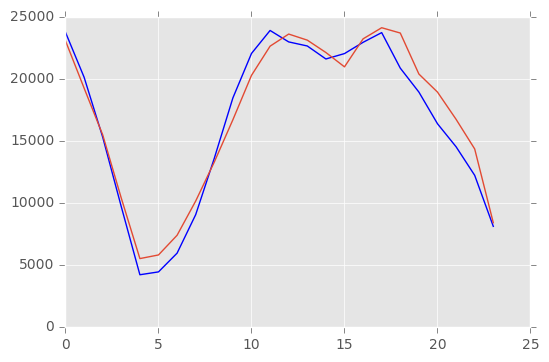

In [10]:
plt.plot(range(24*1), df_total.demand.iloc[:24*1], c='blue')
plt.plot(range(24*1), df_total.prediction.iloc[:24*1]);

In [25]:
%%time
df['mlp_prediction'] = mlp.predict(X, batch_size=10000, verbose=0)[:, 0]

CPU times: user 2min 29s, sys: 10.8 s, total: 2min 40s
Wall time: 57.9 s


In [26]:
df['mlp_prediction'] = np.maximum(df['mlp_prediction'], 0)
df.head()

,date,dayofweek,hour,geohash,demand,lat,lon,road_density,intxn_density,weekend,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,prev_demand,mlp_prediction
16593,1,6,1,dr5qup0,0,40.600662,-74.003220,37,2,1,0.755975,0.6546,0.041655,0.999132,0,0
16596,1,6,1,dr5qup4,0,40.600662,-74.000473,36,2,1,0.755975,0.6546,0.041655,0.999132,0,0
16597,1,6,1,dr5qup5,0,40.600662,-73.999100,25,1,1,0.755975,0.6546,0.041655,0.999132,0,0
16604,1,6,1,dr5qupn,0,40.600662,-73.994980,26,1,1,0.755975,0.6546,0.041655,0.999132,1,0
16605,1,6,1,dr5qupp,0,40.600662,-73.993607,22,0,1,0.755975,0.6546,0.041655,0.999132,0,0


In [27]:
zones = pd.read_csv('engine/data/zones.csv', index_col='geohash')
df = df.merge(zones.reset_index()[['geohash', 'taxi_zone']], how='left', on='geohash')
df_zone = df.groupby(['date', 'dayofweek', 'hour', 'taxi_zone'])[['demand', 'mlp_prediction']].sum()
df_zone = df_zone.reset_index()
df_zone.head()

,date,dayofweek,hour,taxi_zone,demand,mlp_prediction
0,1,6,1,2,0,0.000000
1,1,6,1,3,242,230.671158
2,1,6,1,6,279,170.156097
3,1,6,1,7,1,0.000000
4,1,6,1,8,0,0.000000


In [29]:
rmse = np.sqrt(((df_zone.demand-df_zone.mlp_prediction)**2).mean())
rmse

182.00123411326089